In [1]:
import tensorflow as tf
import pandas as pd
import ast
!pip install -U nltk
from nltk.tokenize import sent_tokenize, word_tokenize
!pip install -U gensim
import gensim
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import SpectralClustering

!pip install -U ipywidgets

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
!pip install -U seaborn
import seaborn as sns
from nltk.data import find

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
import logging
from transformers import logging as hf_logging
from transformers import LongformerModel, LongformerTokenizer

import torch

D0530 05:29:43.509003529      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0530 05:29:43.509027864      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0530 05:29:43.509031345      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0530 05:29:43.509034223      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0530 05:29:43.509036757      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0530 05:29:43.509039389      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0530 05:29:43.509041965      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0530 05:29:43.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 KB 43.2 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 47.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 4.7 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 KB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.1 MB/s eta 0:00:0000:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 5.2 MB/s eta 0:00:00a 0:00:01
You should cons

In [46]:
full_data = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [47]:
# Data Preprocessing
imp_data = full_data[['id', 'overview', 'title', 'keywords']]

summaries = imp_data['overview'][:5].reset_index(drop=True)
titles = imp_data['title'][:5].reset_index(drop=True)
ids = imp_data['id'][:5].reset_index(drop=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print(summaries)

In [48]:
# Set TPU strategy
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [49]:
import tensorflow as tf
from transformers import TFLongformerModel, LongformerTokenizer
import numpy as np
import gc
import time
import sys

# Tokenize all the summaries
def longformer_tokenize_data(tokenizer, summaries):
    tokenized_summaries = []
    for summary in summaries:
        # Tokenize the text
        tokenized_summary = tokenizer(summary, truncation=True, max_length=4096, padding='max_length', return_tensors="tf")
        tokenized_summaries.append(tokenized_summary)
    return tokenized_summaries

# Wrap the model call in strategy.scope
with strategy.scope():
    model = TFLongformerModel.from_pretrained('allenai/longformer-base-4096')

# Instantiate the Longformer model and tokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Tokenize summaries with LongformerTokenizer
#start = time.time()
processed_data = longformer_tokenize_data(tokenizer, summaries)
#stop = time.time()
#print("Tokenizer Step for all summaries: ", stop - start, " seconds")
#print("\n")

with strategy.scope():
    # Process the data
    summary_embeddings = []
    for i, data in enumerate(processed_data):
        # start2 = time.time()
        input_ids = data['input_ids']
        attention_mask = data['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        summary_embeddings.append(outputs[0])
        # stop2 = time.time()
        # print("Time for embedding ", i, ": ", stop2 - start2, " seconds")

# Reshape output embeddings by taking the mean across sequence_length dimension
# and squeezing to remove batch_size dimension
embeddings = [np.mean(x.numpy(), axis=1).squeeze() for x in summary_embeddings]

# Memory Cleanup
del summary_embeddings
gc.collect()

# Set print options
np.set_printoptions(threshold=sys.maxsize)

embeddings = np.array(embeddings)

np.save('/kaggle/working/summary_embeddings.npy', embeddings)

# Output: NumPy array of vector embeddings
print(embeddings.shape)

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


(5, 768)


In [50]:
from sklearn.cluster import KMeans

number_of_clusters = 2

# Perform clustering with KMeans
clustering = KMeans(n_clusters=number_of_clusters, random_state=7).fit(embeddings)

/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


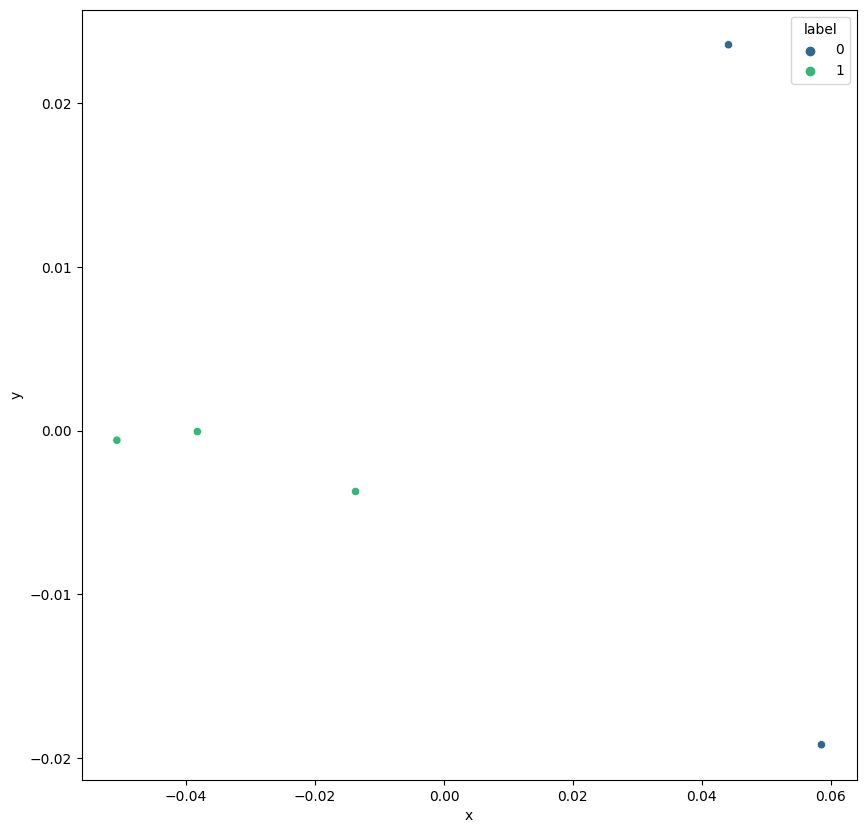

Cluster 0 summaries:
      ID                  Title                                            Summary
3  49026  The Dark Knight Rises  Following the death of District Attorney Harve...
4  49529            John Carter  John Carter is a war-weary, former military ca...


Cluster 1 summaries:
       ID                                     Title                                            Summary
0   19995                                    Avatar  In the 22nd century, a paraplegic Marine is di...
1     285  Pirates of the Caribbean: At World's End  Captain Barbossa, long believed to be dead, ha...
2  206647                                   Spectre  A cryptic message from Bond’s past sends him o...




In [51]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the processed_data_array
num_samples, embedding_dim = embeddings.shape

reshaped_data_array = embeddings.reshape(num_samples, embedding_dim)

# PCA for dimension reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(reshaped_data_array)

# Create a DataFrame for easy plotting
df = pd.DataFrame(reduced_data, columns=['x', 'y'])
df['label'] = clustering.labels_
df['Title'] = titles
df['Summary'] = summaries
df['ID'] = ids

# Plot using seaborn
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend=True)
plt.show()

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Print out summaries from each cluster
for i in range(number_of_clusters):  # Change this range depending on which clusters you want to look at
    print(f'Cluster {i} summaries:')
    print(df[df['label'] == i][['ID', 'Title', 'Summary']])
    print('\n')

In [ ]:
# Get largest cluster size

# cluster_counts = df['label'].value_counts()
# largest_cluster = cluster_counts.idxmax()
# largest_cluster_size = cluster_counts.max()

# print(f"The largest cluster is: {largest_cluster} with size: {largest_cluster_size}")